# Apply network partition & visualize FC matrices

**Public code release for**: A Network Science Cartography of Cognitive Control System Dynamics  
**PhD Candidate Qualifying Examination**, Rutgers University Center for Molecular and Behavioral Neuroscience, 2018  
**Carrisa Cocuzza** (carrisacocuzza@gmail.com), The Cole Lab (http://www.colelab.org/)  

## Summary

**Demo**: loads in parcellated (preferred: Glasser, 2016) functional connectivity (FC) matrices, applies the Cole-Anticevic (CA) partition, finds resting-state reassignments, applies those empirically-driven adjustments to the CA partition and visualizes the reulting sorted matrices for rest and task states. 

**Input notes**: Data should be in size [region x region x state x sample size] for example, 360 node adjacency matrices for 12 task states, across n=2 participants is of size [360 x 360 x 12 x 2] 12 task states = the 64 C-PRO rule sets, collapsed by each rule being uniquely represented (see paper for more details)

## Housekeeping

In [1]:
## Load & import 

import sys
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as spio
import pickle
baseDir = '/Users/carrisacocuzza/AnacondaProjects/LearningFlexHub_GIT/'; # CHANGE ME 

# Rest data (pre-estimated in MATLAB and saved as a .mat file)
restDataMat = spio.loadmat(baseDir + 'restData.mat'); restData = restDataMat['restData'];

# Task FC data (pre-estimated in MATLAB and saved as a .mat file)
taskDataMat = spio.loadmat(baseDir + 'taskData.mat'); taskData = taskDataMat['taskData'];
[numNodes,numNodes,numTasks,numSubjs] = taskData.shape;

##  CA Partition information (pre-saved, see: netStruct.m)
##  Empirical adjustment to the CA partition (pre-saved, see: restPartitionAdjuster.m)

# nodeOrder is an index vector to reorder Glasser parcels into the CA partition
nodeOrderVec = spio.loadmat(baseDir + 'nodeOrderPyVer.mat');
nodeOrder = nodeOrderVec['nodeOrderPyVer']; nodeOrderArr = np.array(nodeOrder);

# nodeOrderNew is an index vector to reorder Glasser parcels into the CA partition, empirically-adjusted
# previously calculated with restPartitionAdjuster.m (MATLAB function) for n=50
nodeOrderNewVec = spio.loadmat(baseDir + 'nodeOrderNewPyVer.mat');
nodeOrderNew = nodeOrderNewVec['nodeOrderNewPyVer']; nodeOrderNewArr = np.array(nodeOrderNew);

# nodeIndices shows the CA network assignments of un-ordered Glasser parcels 
nodeIndicesVec = spio.loadmat(baseDir + 'nodeIndicesPyVer.mat');
nodeIndices = nodeIndicesVec['nodeIndicesPyVer']; nodeIndicesArr = np.array(nodeIndices);

# nodeIndicesNew shows the CA network assignments of un-ordered Glasser parcels, empirically-adjusted
# previously calculated with restPartitionAdjuster.m (MATLAB function) for n=50
nodeIndicesNewVec = spio.loadmat(baseDir + 'nodeIndicesNewPyVer.mat');
nodeIndicesNew = nodeIndicesNewVec['nodeIndicesNewPyVer']; nodeIndicesNewArr = np.array(nodeIndicesNew);

# boundaries is a matrix containing start and end node ranges for the CA partition 
boundariesMat = spio.loadmat(baseDir + 'boundariesPyVer.mat');
boundaries = boundariesMat['boundariesPyVer'];
boundariesArr = np.array(boundaries); 

# boundariesNew is a matrix containing start and end node ranges for the empirical adjustment to CA partition
# previously calculated with restPartitionAdjuster.m (MATLAB function) for n=50
boundariesNewMat = spio.loadmat(baseDir + 'boundariesNewPyVer.mat');
boundariesNew = boundariesNewMat['boundariesNewPyVer'];
boundariesNewArr = np.array(boundariesNew); 

# network names & coloring conventions 
colorMapMat = spio.loadmat(baseDir + 'colorMapNets.mat');
colorMapNets = colorMapMat['colorMapNets'];
netNamesMat = spio.loadmat(baseDir + 'netNames.mat');
netNames = netNamesMat['netNames'];

numNets = 12; 

## Partition work 

In [2]:
## Apply empirically-adjusted CA partition to resting state data (indexed over subjects)

restCA = restData[:,nodeOrder,:][nodeOrder,:,:]; restOrderedCA = np.squeeze(restCA);
restAdj = restOrderedCA[:,nodeOrderNew,:][nodeOrderNew,:,:]; 
restOrdered = np.squeeze(restAdj); 

/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'avenir'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


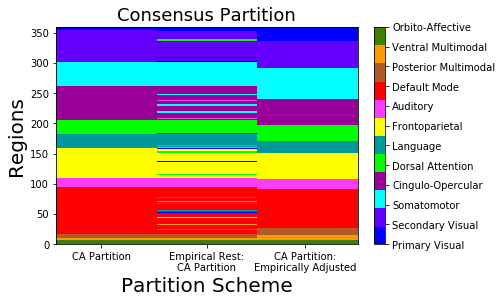

In [3]:
## Visualize partition scheme across subjects

with open("colorList.txt","rb") as fp:
    colorList = pickle.load(fp)
    
cmap = mpl.colors.ListedColormap(colorList); cmap.set_over('0.25'); cmap.set_under('0.75');
netListStr = ['Primary Visual','Secondary Visual','Somatomotor','Cingulo-Opercular',
                      'Dorsal Attention','Language','Frontoparietal','Auditory','Default Mode',
                      'Posterior Multimodal','Ventral Multimodal','Orbito-Affective'];
# Original CA partition (e.g., ideal reference)
caPartitionOrig = nodeIndices[nodeOrder]; caPartition = np.reshape(caPartitionOrig,[numNodes,1]); 
caPartitionFull = np.tile(caPartition,numSubjs); caPartitionFull = caPartitionFull.astype(int);

# Empirical rest data preferences, in reference to the CA partition
maxIndices = np.argmax(restOrdered,axis=0); maxIndicesSqueeze = np.squeeze(maxIndices);
caPartitionRest = maxIndicesSqueeze; 

# Re-assigned partition by data's empirical resting state preferences 
restReassignedOrig = nodeIndicesNew; 
restReassigned = np.reshape(restReassignedOrig,[numNodes,1]);
restReassignedFull = np.tile(restReassigned,numSubjs);

# Empirical rest data, reassigned 
restPartition = caPartitionRest[nodeOrderNew]; 

# Visualize
caVecs = np.hstack((caPartition,nodeIndicesNew));
orderedTemp = nodeIndicesNew[nodeOrderNew]; 
orderedNodes = np.reshape(orderedTemp,(360,1));
newVecs = np.hstack((nodeIndicesNew,orderedNodes));
bigMat = np.hstack((caVecs,orderedNodes));
netList = list(range(numNets));

cAx = plt.imshow(bigMat,cmap=cmap,extent=[0,1,0,360], aspect='auto');
cBarH = plt.colorbar(fraction=.05); cBarH.set_ticks([netList]);
cBarH.set_ticklabels(netListStr); plt.xticks([0.15,0.5,0.825]); 
ax = plt.gca(); ax.set_xticklabels(['CA Partition','Empirical Rest:\n' + 'CA Partition',
                    'CA Partition:\n' +'Empirically Adjusted']);
plt.ylabel('Regions',fontsize=20,fontname='avenir');
plt.xlabel('Partition Scheme',fontsize=20,fontname='avenir');
plt.title('Consensus Partition', fontsize=18, y=1, fontname='avenir');


In [4]:
## Get grand mean FC matrices with adjusted partition scheme 
# Fisher's Z transform for stabilization of variance 

# Rest
restOrdered = restData[:,nodeOrder,:][nodeOrder,:,:];
restSqueeze = np.squeeze(restOrdered);
restOrderedNew = restSqueeze[:,nodeOrderNew,:][nodeOrderNew,:,:];
restSqueezeNew = np.squeeze(restOrderedNew);
restFish = np.arctan(restSqueezeNew);
meanRestFish = np.nanmean(restFish,axis=2);
meanRest = np.tanh(meanRestFish);
from numpy import nan
np.fill_diagonal(meanRest, nan);

# Task 
taskOrdered = taskData[:,nodeOrder,:,:][nodeOrder,:,:,:];
taskSqueeze = np.squeeze(taskOrdered);
taskOrderedNew = taskSqueeze[:,nodeOrderNew,:,:][nodeOrderNew,:,:,:];
taskSqueezeNew = np.squeeze(taskOrderedNew);
taskFishSubjs = np.arctan(taskSqueezeNew);
meanTaskFishSubjs = np.nanmean(taskFishSubjs,axis=3);
meanTaskSubjs = np.tanh(meanTaskFishSubjs);
taskFish = np.arctan(meanTaskSubjs);
meanTaskFish = np.nanmean(taskFish,axis=2);
meanTask = np.tanh(meanTaskFish);


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


## FC Visualizations 

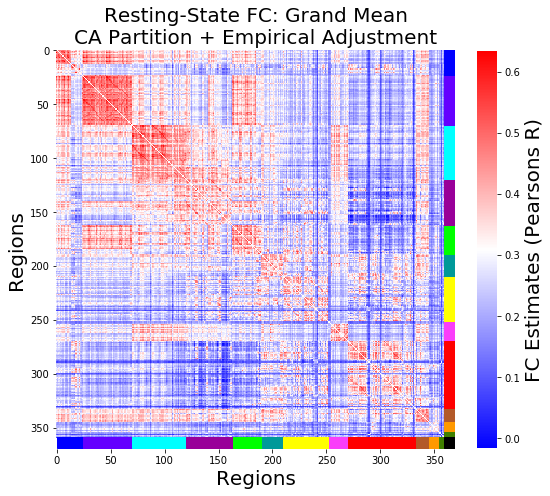

In [5]:
## Visualize resting-state FC grand mean (rsFC)

bottomSize = (10,numNodes); topSize = (numNodes+10,10); 
bottomBuff = np.zeros(bottomSize); topBuff = np.zeros(topSize);
bottomBuff = (bottomBuff+1)*0.31; topBuff = (topBuff+1)*0.31; 
bottomAdd = np.vstack((meanRest,bottomBuff)); meanRestBuff = np.hstack((bottomAdd,topBuff));

np.fill_diagonal(meanRestBuff, 0.31);

fig,ax = plt.subplots(1,figsize=(7,7),facecolor=(1,1,1));

plt.imshow(meanRestBuff, cmap='bwr', interpolation='none');
plt.title('Resting-State FC: Grand Mean\n' + 'CA Partition + Empirical Adjustment', 
          fontsize=20, y=1, fontname='avenir');
plt.ylabel('Regions',fontsize=20,fontname='avenir');
plt.xlabel('Regions',fontsize=20,fontname='avenir');
cBarH = plt.colorbar(fraction=.045); cBarH.outline.set_visible(False);
cBarH.set_label('FC Estimates (Pearson''s R)', size=20,fontname='avenir')
plt.subplots_adjust(left=None, bottom=None, right=1, top=1, wspace=1, hspace=1);

import matplotlib.patches as patches; cL = colorList; 
for net in netList:
    netSize = boundariesNew[net,2]; netStart = boundariesNew[net,0];
    rectH = patches.Rectangle((netStart,359),netSize,10,linewidth=1,edgecolor=cL[net],facecolor=cL[net]); 
    rectV = patches.Rectangle((359,netStart),10,netSize,linewidth=1,edgecolor=cL[net],facecolor=cL[net]); 
    ax.add_patch(rectH); ax.add_patch(rectV);

rectBlack = patches.Rectangle((359,359),10,10,linewidth=1,edgecolor='k',facecolor='k'); 
ax.add_patch(rectBlack); plt.box('off'); plt.show()

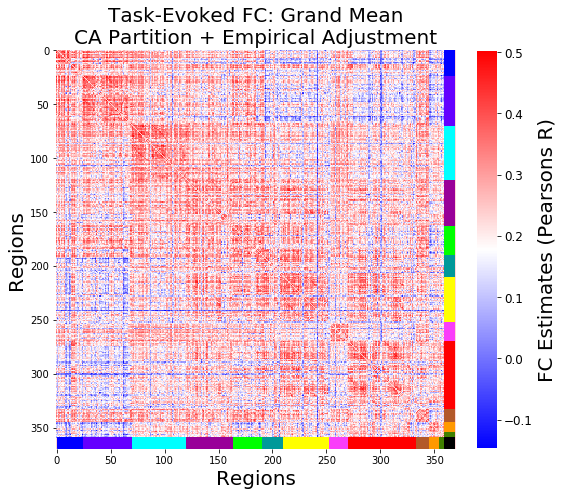

In [6]:
## Visualize task-evoked FC grand mean (tFC)

bottomSize = (10,numNodes); topSize = (numNodes+10,10); 
bottomBuff = np.zeros(bottomSize); topBuff = np.zeros(topSize);
bottomBuff = (bottomBuff+1)*0.23; topBuff = (topBuff+1)*0.23; 
bottomAdd = np.vstack((meanTask,bottomBuff)); meanTaskBuff = np.hstack((bottomAdd,topBuff));

np.fill_diagonal(meanTaskBuff, 0.23);
 
fig,ax = plt.subplots(1,figsize=(7,7),facecolor=(1,1,1));

plt.imshow(meanTaskBuff, cmap='bwr', interpolation='none');
plt.title('Task-Evoked FC: Grand Mean\n' + 'CA Partition + Empirical Adjustment', 
          fontsize=20, y=1, fontname='avenir');
plt.ylabel('Regions',fontsize=20,fontname='avenir');
plt.xlabel('Regions',fontsize=20,fontname='avenir');
cBarH = plt.colorbar(fraction=.045);  cBarH.outline.set_visible(False);
cBarH.set_label('FC Estimates (Pearson''s R)', size=20,fontname='avenir');
cBarH.ax.tick_params(labelsize=12);

plt.subplots_adjust(left=None, bottom=None, right=1, top=1, wspace=1, hspace=1);

import matplotlib.patches as patches; cL = colorList; 
for net in netList:
    netSize = boundariesNew[net,2]; netStart = boundariesNew[net,0];
    rectH = patches.Rectangle((netStart,359),netSize,10,linewidth=1,edgecolor=cL[net],facecolor=cL[net]); 
    rectV = patches.Rectangle((359,netStart),10,netSize,linewidth=1,edgecolor=cL[net],facecolor=cL[net]); 
    ax.add_patch(rectH); ax.add_patch(rectV);

rectBlack = patches.Rectangle((359,359),10,10,linewidth=1,edgecolor='k',facecolor='k'); 
ax.add_patch(rectBlack); plt.box('off'); plt.show()

In [8]:
## Some brief comparisons between rest and task (see manuscript for more detailed analyses)

import math as math 

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)
    r = (a*b).sum() / math.sqrt((a*a).sum() * (b*b).sum());
    return r

np.fill_diagonal(meanRest, 0);
np.fill_diagonal(meanTask, 0);

restTaskCorr =  corr2(meanRest,meanTask);

print('The 2D correlation coefficient between rest FC and task FC is r=' + str(restTaskCorr))

The 2D correlation coefficient between rest FC and task FC is r=0.5711315616290582


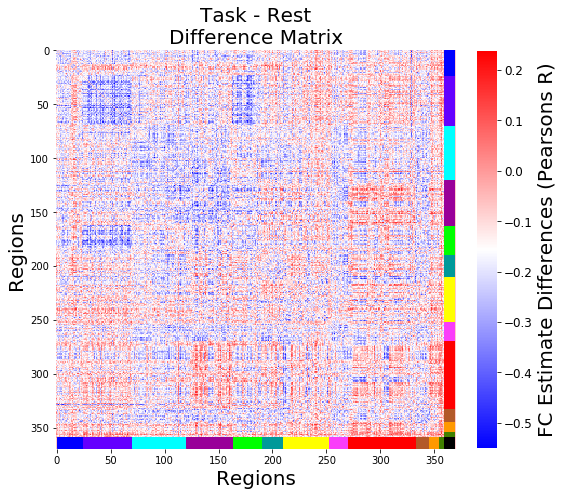

In [8]:
# Difference matrix

diffMat = meanTask - meanRest; 

bottomSize = (10,numNodes); topSize = (numNodes+10,10); 
bottomBuff = np.zeros(bottomSize); topBuff = np.zeros(topSize);
bottomBuff = (bottomBuff+1)*-0.075; topBuff = (topBuff+1)*-0.075; 
bottomAdd = np.vstack((diffMat,bottomBuff)); fullBuff = np.hstack((bottomAdd,topBuff));

np.fill_diagonal(fullBuff, -0.075);

fig,ax = plt.subplots(1,figsize=(7,7),facecolor=(1,1,1));

plt.imshow(fullBuff, cmap='bwr', interpolation='none');
plt.title('Task - Rest\n' + 'Difference Matrix', fontsize=20, y=1, fontname='avenir');
plt.ylabel('Regions',fontsize=20,fontname='avenir'); plt.xlabel('Regions',fontsize=20,fontname='avenir');
cBarH = plt.colorbar(fraction=.045); cBarH.outline.set_visible(False);
cBarH.set_label('FC Estimate Differences (Pearson''s R)', size=20,fontname='avenir');
cBarH.ax.tick_params(labelsize=12);

plt.subplots_adjust(left=None, bottom=None, right=1, top=1, wspace=1, hspace=1);

import matplotlib.patches as patches; cL = colorList; 
for net in netList:
    netSize = boundariesNew[net,2]; netStart = boundariesNew[net,0];
    rectH = patches.Rectangle((netStart,359),netSize,10,linewidth=1,edgecolor=cL[net],facecolor=cL[net]); 
    rectV = patches.Rectangle((359,netStart),10,netSize,linewidth=1,edgecolor=cL[net],facecolor=cL[net]); 
    ax.add_patch(rectH); ax.add_patch(rectV);

rectBlack = patches.Rectangle((359,359),10,10,linewidth=1,edgecolor='k',facecolor='k'); 
ax.add_patch(rectBlack); plt.box('off'); plt.show()